In [1]:
# Load Libraries
import pandas as pd
import numpy as np
from keras.models import load_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib
import sqlite3
import matplotlib.pyplot as plt


In [2]:

# Define the default ticker to evaluate
default_ticker = "XOM"
print(f"Evaluating model for Ticker: {default_ticker}")

# Path to SQLite database and saved models
db_path = 'database/stocks_data.db'

# Load Test Data
with sqlite3.connect(db_path) as conn:
    query = "SELECT * FROM processed_stocks"
    data = pd.read_sql(query, conn)

print(f"Loaded data for evaluation: {data.shape[0]} rows")


Evaluating model for Ticker: XOM
Loaded data for evaluation: 178922 rows


In [3]:

# Feature Engineering: Recreate the missing features in the correct order
data['Lag_1'] = data['Adj Close'].shift(1)
data['Lag_2'] = data['Adj Close'].shift(2)
data['Lag_3'] = data['Adj Close'].shift(3)
data['Volatility'] = data['Adj Close'].rolling(window=7).std()
data['Momentum'] = data['Adj Close'].pct_change(periods=3)

# Drop rows with NaN values introduced by feature engineering
data = data.dropna()
print(f"Data after feature engineering: {data.shape[0]} rows")


Data after feature engineering: 178916 rows


In [4]:

# Load the scaler and retrieve the exact features used during training
scaler_path = f'models/scaler_{default_ticker}_lstm.pkl'
scaler = joblib.load(scaler_path)
print(f"Loaded scaler for Ticker: {default_ticker}")


Loaded scaler for Ticker: XOM


In [5]:

# Retrieve feature names from the scaler (for alignment)
trained_feature_names = scaler.feature_names_in_
print(f"Feature names used during training: {list(trained_feature_names)}")


Feature names used during training: ['7-day MA', '14-day MA', 'Volatility', 'Lag_1', 'Lag_2', 'Lag_1', 'Lag_2', 'Lag_3', 'Volatility', 'Momentum']


In [6]:

# Define target
target = 'Adj Close'

# Align features with training order
X = data[trained_feature_names]
y = data[target]


In [7]:

# Load the LSTM model
model_path = f'models/model_{default_ticker}_lstm.h5'
model = load_model(model_path, compile=False)
print(f"Loaded LSTM model for Ticker: {default_ticker}")


Loaded LSTM model for Ticker: XOM


In [8]:

# Normalize the features
X_scaled = scaler.transform(X)

# Reshape the features for LSTM (samples, timesteps, features)
X_scaled = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])

# Make Predictions
y_pred = model.predict(X_scaled)


5592/5592 ━━━━━━━━━━━━━━━━━━━━ 3s 588us/step


In [9]:

# Evaluate Model Performance
mse = mean_squared_error(y, y_pred)
mae = mean_absolute_error(y, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y, y_pred)

print("LSTM Model Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")


LSTM Model Evaluation Metrics:
Mean Squared Error (MSE): 1.64
Mean Absolute Error (MAE): 0.60
Root Mean Squared Error (RMSE): 1.28
R² Score: 1.00


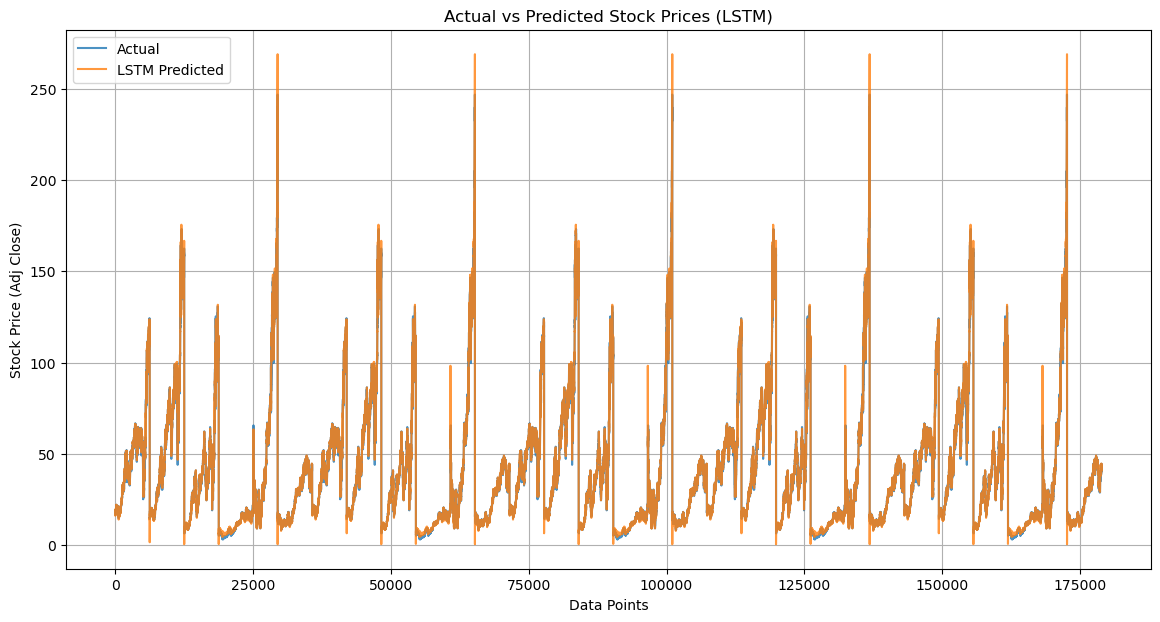

In [10]:

# Visualization: Actual vs Predicted Values
plt.figure(figsize=(14, 7))
plt.plot(y.values, label='Actual', alpha=0.8)
plt.plot(y_pred.flatten(), label='LSTM Predicted', alpha=0.8)
plt.title('Actual vs Predicted Stock Prices (LSTM)')
plt.xlabel('Data Points')
plt.ylabel('Stock Price (Adj Close)')
plt.legend()
plt.grid()
plt.show()


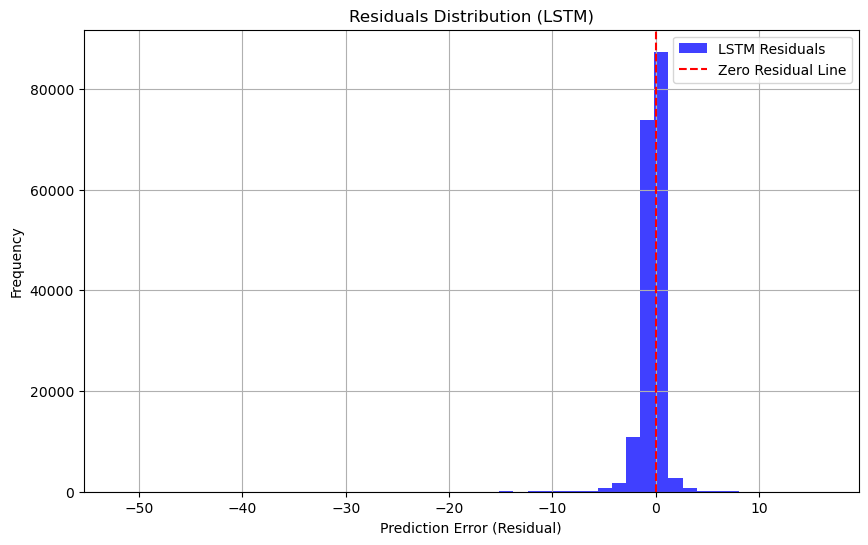

In [11]:

# Visualization: Residuals
residuals_lstm = y - y_pred.flatten()

plt.figure(figsize=(10, 6))
plt.hist(residuals_lstm, bins=50, alpha=0.75, color='blue', label='LSTM Residuals')
plt.axvline(x=0, color='red', linestyle='--', label="Zero Residual Line")
plt.title('Residuals Distribution (LSTM)')
plt.xlabel('Prediction Error (Residual)')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()


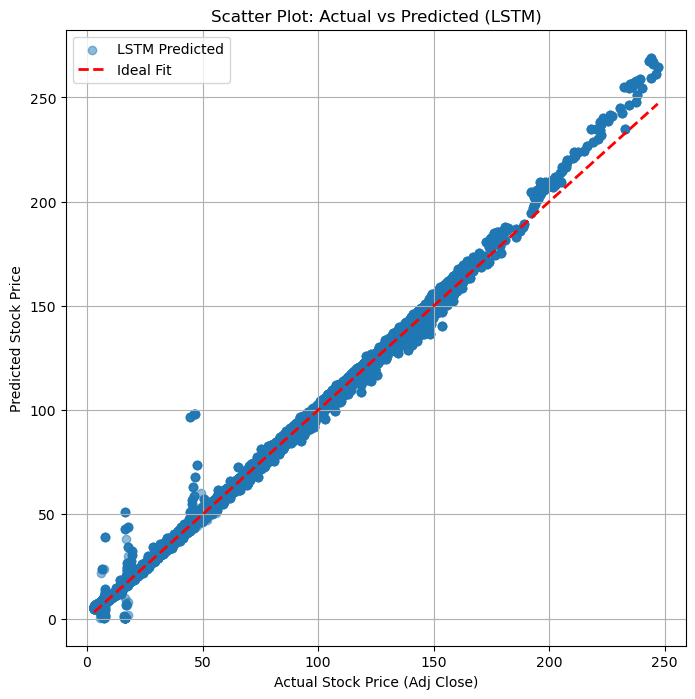

In [12]:

# Visualization: Scatter Plot of Actual vs Predicted
plt.figure(figsize=(8, 8))
plt.scatter(y, y_pred, alpha=0.5, label='LSTM Predicted')
plt.plot([min(y), max(y)], [min(y), max(y)], color='red', linestyle='--', linewidth=2, label='Ideal Fit')
plt.title('Scatter Plot: Actual vs Predicted (LSTM)')
plt.xlabel('Actual Stock Price (Adj Close)')
plt.ylabel('Predicted Stock Price')
plt.legend()
plt.grid()
plt.show()